# dev nearest-neighbor tracking with periodic boundary conditions
Tim Tyree<br>
6.29.2022

In [1]:
use_clear_output=True
if use_clear_output:
    from IPython.display import clear_output
    clear_output(wait=True)

import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

os.chdir(nb_dir)
from lib import *

# import cupy, cudf
# from lib.rapids_func import *

import seaborn as sns
import matplotlib.ticker as mtick

#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

In [2]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [3]:
def load_tip_pos_from_csv(input_dir,round_t_to_n_digits=7,t_col='t',
                          reset_index=True,printing=True,**kwargs):
    """
    Example Usage:
df=load_tip_pos_from_csv(input_dir,round_t_to_n_digits=7,printing=True)
    """
    df=pd.read_csv(input_dir)
    df[t_col]=np.around(df[t_col],round_t_to_n_digits)
    if printing:
        print(f"{df.shape=}")
    df.drop_duplicates(inplace=True)
    if printing:
        print(f"{df.shape=}")
    if reset_index:
        df.reset_index(inplace=True)
    return df

In [4]:
#TODO: move to lib.utils.utils_traj.py
def find_nearest_neighbor_simple(xy,xy_others,distance_L2_pbc):
    """returns (nearest_id,nearest_dist) from xy_others, where distance is computed by distance_L2_pbc.
    note that distance_L2_pbc does not necessarily need to be the L2 norm with periodic boundary conditions.
    distance_L2_pbc has the signature:
    dist = distance_L2_pbc ( xy_others[j], xy)
    
    Example Usage:    
distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)
nearest_id, nearest_dist = find_nearest_neighbor_simple(xy,xy_others,distance_L2_pbc)
    """
    num_other=xy_others.shape[0]
    nearest_id   =  -1
    nearest_dist = 9999.
    for j in range(num_other):
        dist = distance_L2_pbc ( xy_others[j], xy)
        if dist<nearest_dist:
            nearest_dist = dist
            nearest_id  = j
    return nearest_id, nearest_dist

In [5]:
def comp_consistent_nearest_neighbors(map_prev_next,map_next_prev):
    """for each key of map_prev_next, look for consistent nearest neighbors
    map_prev_next and map_next_prev are dictionaries that map indices from prev to/from next, respectively.
    
    Example Usage:
id_pair_lst=comp_consistent_nearest_neighbors(map_prev_next,map_next_prev)
dict_map_prev_next_consistent=dict(id_pair_lst)
    """
    id_pair_lst=[]
    for key_next in map_next_prev:
        key_prev=map_next_prev[key_next]
        if map_prev_next[key_prev]==key_next:
            #record key match
            id_pair_lst.append((key_prev,key_next))
    return id_pair_lst
#     id_pair_lst=[]
#     for key_prev in map_prev_next:
#         key_next=map_prev_next[key_prev]
#         if map_next_prev[key_next]==key_prev:
#             #record key match
#             id_pair_lst.append((key_prev,key_next))
#     return id_pair_lst
    


In [6]:
def find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc,xy_col_lst=['x','y'],**kwargs):
    """find_nearest_neighbors_pbc returns a list of pairs of indices, where each pair indexes 
    a member of d_prev and d_next that are mutually nearest neighbors, respectively.
    distance_L2_pbc is passed to find_nearest_neighbor_simple directly
    Example Usage:
id_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
    """
    #extract positions
    xy_prev=d_prev[xy_col_lst].values.copy()
    xy_next=d_next[xy_col_lst].values.copy()
    #compute the map from prev to next
    map_prev_next={}
    for i,xy_self in enumerate(xy_prev):
        #compute the nearest neighbor
        nearest_id, nearest_dist = find_nearest_neighbor_simple(xy=xy_self,xy_others=xy_next,distance_L2_pbc=distance_L2_pbc)
        map_prev_next[i]=nearest_id
    #compute the map from next to prev
    map_next_prev={}
    for i,xy_self in enumerate(xy_next):
        #compute the nearest neighbor
        nearest_id, nearest_dist = find_nearest_neighbor_simple(xy=xy_self,xy_others=xy_prev,distance_L2_pbc=distance_L2_pbc)
        map_next_prev[i]=nearest_id
    id_pair_lst=comp_consistent_nearest_neighbors(map_prev_next,map_next_prev)
    return id_pair_lst

In [7]:
def get_map_noother(id_next_values,id_other):
    """compute map from noother_to_all
    Example Usage:
map_noother_to_all=get_map_noother(id_next_values,id_other)
    """
    mappy=dict()
    for i in id_next_values:
        if i<id_other:
            mappy[i]=i
        elif i>id_other:
            mappy[i-1]=i
    map_noother_to_all=mappy
    return map_noother_to_all

In [8]:
def find_nearest_neighbors_noother(d_prev,d_next,id_other_prev,id_other,distance_L2_pbc,xy_col_lst=['x','y'],**kwargs):
    """find_nearest_neighbors_pbc returns a list of pairs of indices, where each pair indexes 
    a member of d_prev and d_next that are mutually nearest neighbors, respectively.
    distance_L2_pbc is passed to find_nearest_neighbor_simple directly
    Example Usage:
id_pair_lst=find_nearest_neighbors_noother(d_prev,d_next,id_other_prev,id_other,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
    """
    #extract positions
    xy_prev=d_prev[xy_col_lst].values.copy()
    xy_next=d_next[xy_col_lst].values.copy()
    id_prev_values=np.arange(xy_prev.shape[0])
    id_next_values=np.arange(xy_next.shape[0])
    
    ##remove other from both
    #compute map from _noother basis to full basis of indices
    map_noother_to_next=get_map_noother(id_next_values,id_other)
    #remove other from next
    boo=(xy_next[id_other]==xy_next)
    boo_not_other=~(boo[:,0]&boo[:,1])
    xy_next=xy_next[boo_not_other].copy()
    #compute map from _noother basis to full basis of indices
    map_noother_to_prev=get_map_noother(id_prev_values,id_other_prev)
    #remove other from prev
    boo=(xy_prev[id_other]==xy_prev)
    boo_not_other=~(boo[:,0]&boo[:,1])
    xy_prev=xy_prev[boo_not_other].copy()

    #compute the map from prev to next
    map_prev_next={}
    for i,xy_self in enumerate(xy_prev):
        #compute the nearest neighbor
        nearest_id, nearest_dist = find_nearest_neighbor_simple(xy=xy_self,xy_others=xy_next,distance_L2_pbc=distance_L2_pbc)
        map_prev_next[map_noother_to_prev[i]]=map_noother_to_next[nearest_id]
    #compute the map from next to prev
    map_next_prev={}
    for i,xy_self in enumerate(xy_next):
        #compute the nearest neighbor
        nearest_id, nearest_dist = find_nearest_neighbor_simple(xy=xy_self,xy_others=xy_prev,distance_L2_pbc=distance_L2_pbc)
        map_next_prev[map_noother_to_next[i]]=map_noother_to_prev[nearest_id]
    #compute nearest neighbors, as before
    id_pair_lst=comp_consistent_nearest_neighbors(map_prev_next,map_next_prev)
    return id_pair_lst

# dev

In [9]:
# #DONE: load the data from bgmc that has pid_explicit
# #HINT: its on ub in bgmc/python/data/local_results
# search_for_file()

In [10]:
#TODO: implement/dev draft of simple tracker like WJ's in physical notebook
def comp_particle_trajectories_pbc_nearest_neighbors_simple(df):
    pass
#input: df  # from df_log
#output: df_traj
#TODO: test simple tracker on the data by comparing 'particle' and 'pid_explicit'. do they all agree exactly?

In [11]:
input_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'
round_t_to_n_digits=7
min_num_obs=10
min_dist=2. #pixels
# width=200
# height=200
width=10
height=10

printing=True
# t_col='t' #don't worry about t_col and such...
#jit compile distance function
distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)
df=load_tip_pos_from_csv(input_dir,round_t_to_n_digits=round_t_to_n_digits,printing=False)

if df.shape[0]<=min_num_obs:
    if printing:
        print(f"Warning: termination event occured before {min_num_obs=} were recorded.")
#     return None
    
#test that the positions are within the computational domain
assert (df['x'].max()<=width)&(df['x'].max()<=height)

# #extract time step
#DT shouldn't be needed utnil the end. use frames instead, unless if it makes getting frames easy
DT=np.max(np.diff(df['t'].drop_duplicates().values))

#define 'frame' field if it doesn't already exist
if not set(df.columns).issuperset({'frame'}):
    # #DONE: test method of computing frame number works
    # assert (np.around((df[t_col]/DT+1),round_t_to_n_digits).astype(int)==df['frame']).all()
#     df['frame']=np.around((df[t_col]/DT+1),round_t_to_n_digits).astype(int)
    df['frame']=np.around((df['t']/DT+1),round_t_to_n_digits).astype(int)

#initialize field 'particle'
df['index_self']=-9999
df['index_other']=-9999
df['dist']=-9999. #distance in pixels

In [12]:
frame_min=df['frame'].min()
frame_max=df['frame'].max()

In [13]:
#compute n(t)
# df_n=df.groupby(by='t')['n'].median().astype('int')
df_n=df.groupby(by='frame')['n'].median().astype('int')
boo_annihilation=df_n.diff()==-2 #for n-2 only
# boo_annihilation=df_n.diff()<0 #for n-2 and n-4 events (complicated)

#identify all annihilation events where n --> n-2
boo_annihiations_exist=boo_annihilation.any()
if not boo_annihiations_exist:
    if printing:
        print("Warning: no annihilations were found.")
    #return None

In [14]:
# #DONE: print confirmation that the mean n value is an integer numerically
# df_n=df.groupby(by=t_col)['n'].mean()
# print(np.unique(df_n.values))

In [15]:
#DONE: identify all transition frames
#identify all transition times
frame_annihilation_values=df_n[boo_annihilation].index.values
frame_annihilation_lst=list((df_n[boo_annihilation].index.values))

use_final_annihilation=True
if use_final_annihilation:
    #compute the first frame when n=0, supposing it is not present in the frame_values
    #note: if this step fails, try the (~complicated) workaround of checking for n=0 in the df
    #note: one row per position does not support n=0 anywhere
    assert not (df['n']==0).any()
    assert (df.tail(1)['n']==2).all()
    #frame_final=(df.tail(1)['frame']+1).values[0]
    frame_final=df['frame'].max()+1
    frame_annihilation_lst.append(frame_final)

#sort the annihilation events in reverse order
frame_annihilation_lst=sorted(frame_annihilation_lst,reverse=True)
if printing:
    print(f"tracking {len(frame_annihilation_lst)} potential annihilation events...")

tracking 8 potential annihilation events...


In [16]:
# frame_max,frame_annihilation

In [17]:
index_annihilation=0
for frame_annihilation in frame_annihilation_lst:
    frame_next=frame_annihilation
    frame_prev=frame_next-1

    #extract data from frame_prev,frame_next
    #boo_available=(df['index_self']<0)&(df['index_other']<0)
    #d_prev=df[(df['frame']==frame_prev)&boo_available].copy()
    d_prev=df[(df['frame']==frame_prev)].copy()
    num_prev=d_prev.shape[0]
    if frame_annihilation<=frame_max:
        #extract d_next like normal
        d_next=df[df['frame']==frame_next].copy()
        num_next=d_next.shape[0]
    else:
        num_next=0
    
    ###################################
    # initialize new tips
    ###################################
    # if (num_next==0)|(num_prev==2): #could cause more edge cases than it fixes...
    if (num_next==0)&(num_prev==2):
        # #identify the new pair if trivial case
        # id_values_prev_new=np.arange(d_prev.shape[0])
        # id_self=id_values_prev_new[0]
        # id_other=id_values_prev_new[1]
        id_self =0  # d_prev.head(1).index.values[0]
        id_other=1 # d_prev.tail(1).index.values[0]
    else:
        # #otherwise identify the new pair in general pbc case
        #find_nearest_neighbors
        id_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
        #identify which two indices are new in the previous frame
        id_pair_values=np.array(id_pair_lst)
        id_values_prev_taken=id_pair_values[:,0]
        id_values_prev=np.arange(d_prev.shape[0])
        id_values_prev_new=np.setdiff1d(id_values_prev,id_values_prev_taken)
        id_self=id_values_prev_new[0]
        id_other=id_values_prev_new[1]
    index_values_prev=d_prev.index.values
    index_self=index_values_prev[id_self]
    index_other=index_values_prev[id_other]
    xy_self=df.loc[index_self,['x','y']].values
    xy_other=df.loc[index_other,['x','y']].values
    dist=distance_L2_pbc(xy_self,xy_other)
    if dist>min_dist:
        num_obs=0
        working=False
    else:
        # initialize next setting
        num_obs=1
        working=True
        #DONE: add check to set working=False if the initial distance between particles is greater than a certain amount
        #record new tips to self and other
        df.loc[index_self,'dist']=dist
        df.loc[index_self,'index_self']=index_annihilation
        df.loc[index_other,'index_other']=index_annihilation
        #compute distance between self and other only

    #end initialization of new tips
    # #DONE: plot the points i just initialized and verify they look reasonable
    # fig,ax=plt.subplots(figsize=(5,5))
    # df[df['index_self']==index_annihilation].plot.scatter(x='x',y='y',ax=ax,color='r',alpha=0.6,marker='v',s=100)
    # df[df['index_other']==index_annihilation].plot.scatter(x='x',y='y',ax=ax,color='r',alpha=0.6,marker='^',s=100)
    # d_prev.plot.scatter(x='x',y='y',ax=ax,color='C0',alpha=0.2,marker='o',s=300)
    # d_next.plot.scatter(x='x',y='y',ax=ax,color='C1',alpha=0.2,marker='o',s=300)
    # # df.loc[index_other].plot.scatter(x='x',y='y',ax=ax,color='r',alpha=0.6)
    # plt.show()

    ##########################################
    # generate annihilating trajectories only
    ##########################################
    # while previous positions are found, grow only the trajectories involved in this annihilation event
    while working:
        #time step backward
        frame_next=frame_prev
        frame_prev=frame_prev-1
        #break if end of data
        if frame_prev<=frame_min:
            working=False

        #extract data from frame_prev,frame_next
        boo_available=(df['index_self']<0)&(df['index_other']<0)
        d_prev=df[(df['frame']==frame_prev)&boo_available].copy()
        #limit d_next to only consider values that have not been assigned to a particle or the just assigned particles
        boo_annihilation=(df['index_self']==index_annihilation)|(df['index_other']==index_annihilation)
        boo_available_next=boo_available|boo_annihilation
        d_next=df[((df['frame']==frame_next)&boo_available_next)].copy()
        #d_next=df[(df['frame']==frame_next)].copy()
        #d_next=df[(df['frame']==frame_next)&boo_available].copy()
        
        #DONE: filter d_prev by taken values
        #compute id_self from index_self
        id_self=int(np.argwhere((d_next['index_self']==index_annihilation).values))
        #compute id_self from index_self
        id_other=int(np.argwhere((d_next['index_other']==index_annihilation).values))

        #find next neighbor match set
        id_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
        #comp inverse pair map
        id_pair_values=np.array(id_pair_lst)
        dict_map_next_prev_consistent = dict(zip(id_pair_values[:,1],id_pair_values[:,0]))
        #determine which matches were found
        id_matched_next=set(dict_map_next_prev_consistent.keys())
        boo_self_matched=id_matched_next.issuperset({id_self})
        boo_other_matched=id_matched_next.issuperset({id_other})
        #check for either particle not found ==> working=False
        if not (boo_self_matched or boo_other_matched):
            working=False
        else:
            #recompute the other if either is found
            if (boo_self_matched and boo_other_matched):
                #simply update both in the local basis
                id_self=dict_map_next_prev_consistent[id_self]
                id_other=dict_map_next_prev_consistent[id_other]
            elif boo_self_matched:
                #one step back self in the local basis
                id_self_prev=dict_map_next_prev_consistent[id_self]
                #compute nearest neighbors without self
                id_pair_lst_noother=find_nearest_neighbors_noother(d_prev,d_next,
                                                   id_other_prev=id_self_prev,
                                                   id_other=id_self,
                                                   distance_L2_pbc=distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
                #comp inverse pair map
                id_pair_values_noother=np.array(id_pair_lst_noother)
                dict_map_next_prev_consistent_noother = dict(zip(id_pair_values_noother[:,1],id_pair_values_noother[:,0]))
                #one step back other in the local basis
                id_other=dict_map_next_prev_consistent_noother[id_other]
                #update id_self
                id_self=id_self_prev
            elif boo_other_matched:
                #one step back other in the local basis
                id_other_prev=dict_map_next_prev_consistent[id_other]
                #compute nearest neighbors without self
                id_pair_lst_noother=find_nearest_neighbors_noother(d_prev,d_next,
                                                   id_other_prev=id_other_prev,
                                                   id_other=id_other,
                                                   distance_L2_pbc=distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
                #comp inverse pair map
                id_pair_values_noother=np.array(id_pair_lst_noother)
                dict_map_next_prev_consistent_noother = dict(zip(id_pair_values_noother[:,1],id_pair_values_noother[:,0]))
                #one step back self in the local basis
                id_self=dict_map_next_prev_consistent_noother[id_self]
                #update id_other
                id_other=id_other_prev
            else:
                print(f"Warning: {num_prev=}, {num_next=}, {boo_self_matched=}, {boo_other_matched=}. breaking...")
                working=False
        if working:
            #record new tips to self and other
            index_values_prev=d_prev.index.values
            index_self=index_values_prev[id_self]
            index_other=index_values_prev[id_other]
            df.loc[index_self,'index_self']=index_annihilation
            df.loc[index_other,'index_other']=index_annihilation
            #compute distance between self and other only
            xy_self=df.loc[index_self,['x','y']].values
            xy_other=df.loc[index_other,['x','y']].values
            dist=distance_L2_pbc(xy_self,xy_other)
            df.loc[index_self,'dist']=dist
            #record increment to num_obs
            num_obs+=1
    #end while
    if min_num_obs>num_obs:
        #TODO: reset any instance of index_annihilation to null in 'index_self' and 'index_other'
        if printing:
            print(f"Warning: {num_obs=} < {min_num_obs=}.  removed {index_annihilation=} from dataframe")
        df.loc[df['index_self']==index_annihilation,'index_self']=-9999
        df.loc[df['index_other']==index_annihilation,'index_other']=-9999
    else:
        #keep this annihilation
        index_annihilation+=1
    #move on to the next annihilation event
    #end for loop over annihilating trajectories
# return df
#end generation annihilating trajectories

In [18]:
dist

1.0212769754506552

In [19]:
index_annihilation, num_obs, boo_self_matched, boo_other_matched

(7, 98, True, True)

In [20]:
#DONE: ROOT CAUSE ANALYSIS ON WHY the wrong id_other is is getting passed to find_nearest_neighbors_noother

# tests of dev

In [21]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [22]:
# index_annihilation_plot=index_annihilation-1
index_annihilation_plot=0
df.loc[df['index_other']==index_annihilation_plot,'index_other'].shape

(975,)

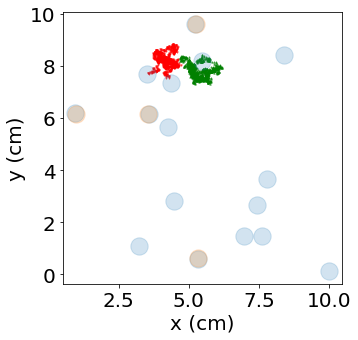

In [23]:
#plot the points i just computed and verify they look reasonable
fig,ax=plt.subplots(figsize=(5,5))
df[df['index_self']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color='r',alpha=0.6,marker='v',s=2)
df[df['index_other']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color='g',alpha=0.6,marker='^',s=2)
d_prev.plot.scatter(x='x',y='y',ax=ax,color='C0',alpha=0.2,marker='o',s=300)
d_next.plot.scatter(x='x',y='y',ax=ax,color='C1',alpha=0.2,marker='o',s=300)
format_plot(ax=ax,xlabel='x (cm)',ylabel='y (cm)')
plt.show()

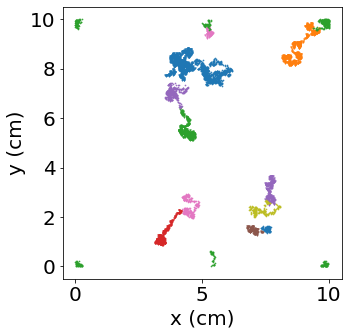

In [37]:
#plot the points i just computed and verify they look reasonable
fig,ax=plt.subplots(figsize=(5,5))
for index_annihilation_plot in range (8):
    df[df['index_self']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color=f'C{index_annihilation_plot}',alpha=0.9,marker='v',s=2)
    df[df['index_other']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color=f'C{index_annihilation_plot*2}',alpha=0.9,marker='.',s=2)
# d_prev.plot.scatter(x='x',y='y',ax=ax,color='C0',alpha=0.2,marker='o',s=300)
# d_next.plot.scatter(x='x',y='y',ax=ax,color='C1',alpha=0.2,marker='o',s=300)
format_plot(ax=ax,xlabel='x (cm)',ylabel='y (cm)')
plt.show()

In [24]:
#DONE: test for equivalence between my particle tracking and the ground truth
#HINT: make dict between particle and pid_explicit, asserting that particle maps to one and only one pid_explicit
#now the big test:
# index_annihilation_test=0
index_annihilation_test=index_annihilation_plot
print(f"Do no more than two known particle identities get assigned to {index_annihilation_test=}?")
pid_explicit_set_lst_self=list(set(df.loc[df['index_self']==index_annihilation_plot,'pid_explicit'].values))
pid_explicit_set_lst_other=list(set(df.loc[df['index_other']==index_annihilation_plot,'pid_explicit'].values))
print(f"{pid_explicit_set_lst_self=}")
print(f"{pid_explicit_set_lst_other=}")
print(f"{num_obs=} is greater than {min_num_obs=}, so this pair-annihilation event is _kept_.")

Do no more than two known particle identities get assigned to index_annihilation_test=0?
pid_explicit_set_lst_self=[3]
pid_explicit_set_lst_other=[7]
num_obs=98 is greater than min_num_obs=10, so this pair-annihilation event is _kept_.


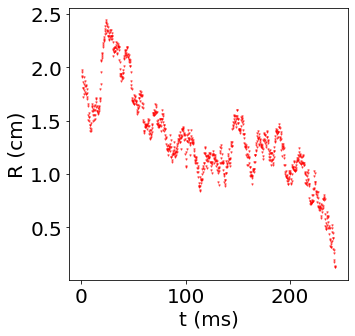

In [25]:
#TODO: simple test for whether results for an example R(t') look reasonable
#plot the points i just computed and verify they look reasonable
fig,ax=plt.subplots(figsize=(5,5))
d=df.loc[df['index_self']==index_annihilation_plot]
d.plot.scatter(x='t',y='dist',ax=ax,color='r',alpha=0.6,marker='v',s=2)
# df[df['index_self']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color='r',alpha=0.6,marker='v',s=2)
# df[df['index_other']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color='g',alpha=0.6,marker='^',s=2)
# d_prev.plot.scatter(x='x',y='y',ax=ax,color='C0',alpha=0.2,marker='o',s=300)
# d_next.plot.scatter(x='x',y='y',ax=ax,color='C1',alpha=0.2,marker='o',s=300)
format_plot(ax=ax,xlabel='t (ms)',ylabel='R (cm)')
plt.show()

In [26]:
#Q: why is the final; distance so far away?
#A: it's just where i killed the simulation, man! Don't worry about it
#TODO: add check to set working=False if the initial distance between particles is greater than a certain amount

In [27]:
d.tail()

,index,frame,t,n,x,y,pid_explicit,index_self,index_other,dist
7134,7134,972,242.75,4,4.590947,8.229685,3,0,-9999,0.197205
7138,7138,973,243.00,4,4.604876,8.229697,3,0,-9999,0.173529
7142,7142,974,243.25,4,4.614060,8.261937,3,0,-9999,0.123376
7146,7146,975,243.50,4,4.595442,8.228966,3,0,-9999,0.125009
7150,7150,976,243.75,4,4.587405,8.211438,3,0,-9999,0.132469


In [28]:
df.tail()

,index,frame,t,n,x,y,pid_explicit,index_self,index_other,dist
85199,85199,39999,9999.50,2,9.295363,6.435280,15,-9999,-9999,-9999.0
85200,85200,40000,9999.75,2,4.330187,3.962795,14,-9999,-9999,-9999.0
85201,85201,40000,9999.75,2,9.253390,6.452116,15,-9999,-9999,-9999.0
85202,85202,40001,10000.00,2,4.335643,3.967257,14,-9999,-9999,-9999.0
85203,85203,40001,10000.00,2,9.322021,6.518097,15,-9999,-9999,-9999.0


In [29]:
#DONE: ROOT CAUSE ANALYSIS: why is index 3 not being returned?
#YEP. #ROOT CAUSE IDENTIFIED: recall annihilating particles vibrate around eachother as they annihilate
#NOPE. #POTENTIAL ROOT CAUSE: map_prev_next,map_next_prev are not inverses of each other
# #simplest fix: recompute the other if either is found
# id_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
# assert len(id_pair_lst)==d_prev.shape[0]

In [30]:
#DONT(this would clearly break it): simple test for whether results for an example R(t') stop looking reasonable if i do:
# d_next=df[df['frame']==frame_next].copy()
# d_next=df[df['frame']==frame_next]